# Assessment: true lift marketing model

Written by Daniel Steinberg and Lachlan McCalman, Gradient Institute Ltd. (info@gradientinstitute.org).

Copyright © 2020 Monetary Authority of Singapore.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


## Introduction

This notebook provides the code used to perform the marketing case study assessment in the FEAT Fairness Principles Assessment Case Studies Document (Dec 2020). Please see Section 2.3 of that document for the marketing case study assessment itself. This code is not intended for use in production or for assessing high risk AIDA systems under the methodology.

This marketing case study assessment is generated from synthetic data. The code to generate the synthetic data is also in this repository, in "uplift_simulation.ipynb".

This work was undertaken as part of the Veritas initiative commissioned by the Monetary Authority of Singapore, whose goal is to accelerate the adoption of responsible Artificial Intelligence and Data Analytics (AIDA) in the financial services industry.



## Scenario

_The following is a running example of a hypothetical, simulated, AIDA direct marketing system used for marketing unsecured loans. Please note that this running example:_ 
- _is evaluated at a high level of detail to illustrate the Methodology applied to a higher risk system_
- _is an example assessment of a system determined by a fictional Financial Services Institution (FSI) to be higher risk, not guidance for FSIs on the actual risk associated with this example (for more details on the risk-based approach of the Methodology see Document 1 Section 2)_
- _is intended to be a simple illustration of how to use the Methodology_
- _does not represent any AIDA systems in place at any of the Veritas Consortium members_
- _should not be taken as guidance for any context- or value-sensitive decision such as choices of fairness objectives, measures, or personal attributes_
- _is not intended to constrain the scope of the Methodology: other uses may have different interventions, products, objectives, and use of AIDA systems_
- _uses simulated data that is not intended to depict realistic statistical relationships or performance measures_
- _has omitted some analyses for the sake of brevity (for example, those relating to harms from default)_

_The terms “we”, “us” or “our” in the running example refer to the functional author of the assessment and not to members of the Consortium as elsewhere in this document._


A (fictional) FSI with a new unsecured “fast & simple” loan product would like to embark on a marketing campaign to its existing (non-exempt) customer base. The FSI will make a profit from the interest rate payments of this product, but this profit will be offset by the cost of the marketing campaign that is carried out through a call centre operated by a different subsidiary company. The purpose of the marketing system under analysis is to select existing customers for a marketing call to increase sales of the product.



## Notation
- $\textrm{App} \in \{0, 1\}$ - Applied (1) or did not apply (0) for the product -- i.e. responded to intervention
- $\textrm{Acq} \in \{0, 1\}$ - Acquired (1) or declined (0) for the product
- $\mathrm{P}_t(\cdot)$ Probability distribution on the treatment cohort
- $\mathrm{P}_c(\cdot)$ Probability distribution on the control cohort
- $G \in \{c, t\}$ - control group, treatment group
- $S \in \{0, 1\}$ - Selected (1) for marketing intervention
- $\mathbf{x} \in \mathbb{R}^D$ - Covariates
- $N(\ldots)$ - Occurrence counts as per the methodology notation
- $\mathrm{Z}(\cdot)$ - Estimated lift rate
- $A$ - Sensitive attribute (protected group is an element in this set)

## Specifics
- \$5,000 personal loans are the product, repayment over 1 year
- \$190 interest at 7% p.a. compounded monthly
- Advertising costs around \$20 per person factoring all costs (wages, call centre costs)

## Goals
- Maximise profit from the marketing system
- Don't increase the number of people being rejected from loan applications by more than 1\%
- Foreigners are rejected at a higher rate than locals (adjusted for income), so be wary of over-allocating the rejection rate to foreigners


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from IPython.display import display
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, make_scorer

In [2]:


from util import load_data, outcomes2labels
from uplift import multiclass_lift, lift_base_rates, Uplifter, OutcomePredictor
from selection import threshold, diff_threshold
from measures import (empirical_lift, deployment_outcomes, std_nlog_loss,
                               make_model_scorer, make_fair_scorer, test_model,
                               mock_deploy, make_impacts, make_fair_impacts,
                               benefit_from_receive, benefit_from_acquire)

%matplotlib notebook
#pd.set_option("precision", 3)

## Settings

In [3]:
# Settings
DEPLOY_NUMBER = 10000
TEST_NUMBER = 10000

RSTATE = 43
USE_ATTRIBUTES = [
    "age",
    #"isfemale",  # May not significantly effect results
    "isforeign"
]  # Use these in the model

GRID_POINTS = 100
COST_TREATMENT = 20
PROFIT_RESPOND = 190
HARM_LEVELS = 100

# Selection strategy for training/model validation
# select all those for whom the model predicts positive lift
TRAINING_THRESH = 0.
selectionfn = partial(threshold, thresh=TRAINING_THRESH)

## Load and split data

<IPython.core.display.Javascript object>


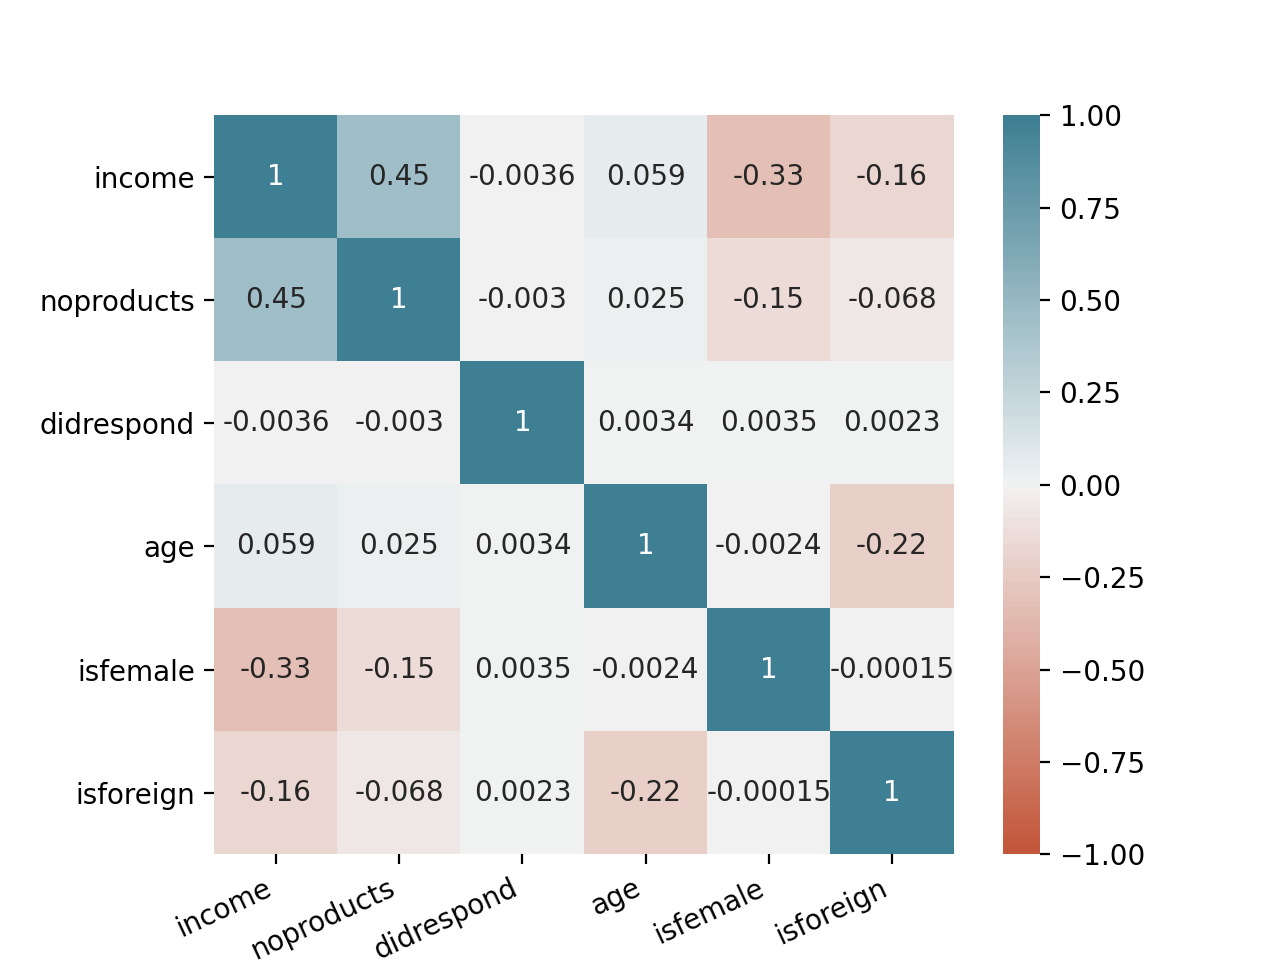

In [4]:
# Load the data, split it into training and query sets
X, A, outcomes, latents = load_data()
y, _ = outcomes2labels(outcomes, A)

# Correlation matrix of X and A
XA = pd.concat((X, A), axis=1)
corr = XA.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=25,
    horizontalalignment='right'
);

In [5]:
# Use protected attributes in the model
if len(USE_ATTRIBUTES) > 0:
    X = pd.concat((X, A[USE_ATTRIBUTES]), axis=1)

    
# Get test data
Xtr, Xts, Atr, Ats, ytr, yts, ltr, lts = train_test_split(
    X, A, y, latents,
    test_size=TEST_NUMBER,
    random_state=RSTATE,
    stratify=y
)

# Get deploy data
Xtr, Xd, Atr, Ad, ytr, yd, ltr, ld = train_test_split(
    Xtr, Atr, ytr, ltr,
    test_size=DEPLOY_NUMBER,
    random_state=RSTATE,
    stratify=ytr
)

In [6]:
X[:10].astype(int)

,income,noproducts,didrespond,age,isforeign
ID,,,,,
0,57052,2,0,41,0
1,29838,2,0,27,0
2,31943,1,0,43,0
3,40282,2,0,35,0
4,45470,4,0,38,0
5,50293,1,0,36,0
6,52133,1,0,50,1
7,32778,2,0,39,1
8,26585,0,0,42,0


### Get loan rejection data, $\textrm{Acq} = 0 \wedge \textrm{App} = 1$

In [7]:
### Make rejection predictor data
def make_rej_targets(y):
    intreatment = np.logical_or((y == "TN").values, (y == "TR").values)
    outcomes = deployment_outcomes(y, intreatment)
    isrej = np.logical_and(outcomes.acquired == 0, outcomes.applied == 1)
    yrej = np.empty_like(y)
    yrej[intreatment] = "T"
    yrej[~intreatment] = "C"
    yrej[isrej] += "R"
    yrej[~isrej] += "N"
    yrej = pd.Series(yrej, index=y.index)
    return yrej
    
yrej_tr = make_rej_targets(ytr)
yrej_ts = make_rej_targets(yts)

## Scoring display functions

In [8]:
# Cross-val scores
def display_measures(score_dict, p_lower=0.05, p_upper=0.95, brake_cols=10):
    cols = [c for c in score_dict.keys() if "time" not in c]
    Ncols = len(cols)
    score_df = pd.DataFrame(score_dict)[cols]
    score_df.columns = [c[5:] for c in cols]
    
    coldisps = np.append(np.arange(0, Ncols, brake_cols), Ncols)
    for cb, ce in zip(coldisps[:-1], coldisps[1:]):
        dispscore = score_df[score_df.columns[cb:ce]]
        desc = dispscore.describe(percentiles=[p_lower, 0.5, p_upper])
        display(desc.loc[["mean", "5%", "50%", "95%", "min", "max"]])
    
    
# Test/Deploy scores
def display_outcomes(outcomes):
    dep_df = pd.DataFrame.from_dict(outcomes, orient="index", columns=["lower 5%", "mean", "upper 95%"])
    display(dep_df)

## Rejection estimation

How many more rejections are due to the marketing system? (As a percentage of the cohort)

\begin{align}
\mathrm{Z}(\textrm{Acq}{=}0, \textrm{App}{=}1) \approx 
    \frac{1}{N} \sum_{i \in \mathcal{S}} 
    \mathrm{P}_t(\textrm{Acq}_i{=}0, \textrm{App}{=}1 | \mathbf{x}_i)
    - \mathrm{P}_c(\textrm{Acq}_i{=}0, \textrm{App}{=}1 | \mathbf{x}_i)
\end{align}

Where $\mathcal{S} = \{n \in \{1, \ldots, N\} | S_n=1\}$ and $\mathrm{P}(\textrm{Acq}_i{=}0, \textrm{App}{=}0) = 0$.

Now we need an estimator for $\mathrm{P}(\textrm{Acq}_i{=}0, \textrm{App}{=}1 | \mathbf{x}_i)$

Cross entropy loss:
\begin{align}
    \mathcal{L}_\textrm{cross ent.}(y, f) &= - \frac{1}{N} \sum_{i=1}^N \sum_{k\in\{\textrm{R-T1}, \ldots, \textrm{R-C0}\}} \mathbf{1}(y_i = k) \log f_k(\mathbf{x}_i), \\
    \mathcal{L}_\textrm{categorical}(y) &= - \frac{1}{N} \sum_{i=1}^N \sum_{k\in\{\textrm{R-T1}, \ldots, \textrm{R-C0}\}} \mathbf{1}(y_i = k) \log \hat{p}_k, \quad \textrm{where} ~ \hat{p}_k = \frac{1}{N} \sum_{i=1}^N \mathbf{1}(y_i = k), \\
    \mathcal{L}_\textrm{std.}(y, f) &= \mathcal{L}_\textrm{cross ent.}(y, f) - \mathcal{L}_\textrm{categorical}(y).
\end{align}

Here $y$ are the targets, $f_k(\mathbf{x})$, is the predictive model’s output of the probability of the target taking value $k$, $\mathbf{x}$, the input covariates, $N$ the size of the dataset to be evaluated, and $K$ the number of target classes (4 in this case). Also, $\mathbf{1}(\cdot)$ is an indicator function returning 1 is the condition in the brackets is true, otherwise 0. The intuition behind this measure is that it will tell us how much better than a biased die roll the prediction model is.

The prediction probabilities obtained from the multiclass classifier have not been adjusted for the disparate size of the control group, $G = c$, and the deployment or treatment group, $G = t$, that is for the rejection uplift estimator,

\begin{align}
    \mathrm{P}(\textrm{Acq}_i{=}0, \textrm{App}_i{=}1, G_i{=}t | \mathbf{x}_i) 
        &\approx f_\textrm{R-T1}(\mathbf{x}_i), \quad \textrm{and} \\
    \mathrm{P}(\textrm{Acq}_i{=}0, \textrm{App}_i{=}1, G_i{=}c | \mathbf{x}_i) 
        &\approx f_\textrm{R-C1}(\mathbf{x}_i).
\end{align}

To approximate the deploy and control distributions we can re-normalise these predictions,

\begin{align}
    \mathrm{P}_t(\textrm{Acq}_i{=}0, \textrm{App}_i{=}1 | \mathbf{x}_i)
    &= \frac{\mathrm{P}(\textrm{Acq}_i{=}0, \textrm{App}_i{=}1, G_i{=}t | \mathbf{x}_i)}
    {\mathrm{P}(G_i{=}t)}\\
    &\approx \frac{f_\textrm{R-T1}(\mathbf{x}_i)}{\sum_{i=1}^N \mathbf{1}(G_i=t) \big/ N},
\end{align}

and similarly,

\begin{align}
    \mathrm{P}_c(\textrm{Acq}_i{=}0, \textrm{App}_i{=}1 | \mathbf{x}_i)
    &= \frac{\mathrm{P}(\textrm{Acq}_i{=}0, \textrm{App}_i{=}1, G_i{=}c | \mathbf{x}_i)}
    {\mathrm{P}(G_i{=}c)}\\
    &\approx \frac{f_\textrm{R-C1}(\mathbf{x}_i)}{\sum_{i=1}^N \mathbf{1}(G_i=c) \big/ N}.
\end{align}

In [9]:
# Train a reject lift predictor
skclf = make_pipeline(
    StandardScaler(),    
    LogisticRegression(multi_class="multinomial", solver="lbfgs"),
)

rejclf = Uplifter(
        liftfn=multiclass_lift,
        selectionfn=selectionfn,
        clf=skclf,
        outcome="reject"
)

# Model performance
model_scorers = {
    "emp_lift": make_model_scorer(empirical_lift),
    "emp_lift_female_r": make_fair_scorer(empirical_lift, prot_attr="isfemale", priv_group=0, diff=False),
    "emp_lift_foreig_r": make_fair_scorer(empirical_lift, prot_attr="isforeign", priv_group=0, diff=False),
    "std_nll": make_scorer(std_nlog_loss, needs_proba=True),
    "snll_female_r": make_fair_scorer(std_nlog_loss, pred_method="predict_proba", prot_attr="isfemale", priv_group=0, diff=False),
    "snll_foreig_r": make_fair_scorer(std_nlog_loss, pred_method="predict_proba", prot_attr="isforeign", priv_group=0, diff=False),
    "bal_acc": make_scorer(balanced_accuracy_score),
    "bacc_female_r": make_fair_scorer(balanced_accuracy_score, pred_method="predict", prot_attr="isfemale", priv_group=0, diff=False),
    "bacc_foreig_r": make_fair_scorer(balanced_accuracy_score, pred_method="predict", prot_attr="isforeign", priv_group=0, diff=False),
}

print("Validating...")
scores_rej = cross_validate(rejclf, Xtr, yrej_tr, scoring=model_scorers, cv=10)

# fit classifier on all training
rejclf.fit(Xtr, yrej_tr)


print("Model selection scores")
display_measures(scores_rej)


print("Model test data scores")
test_rej_outcomes = test_model(rejclf, Xts, yrej_ts, model_scorers)
display_outcomes(test_rej_outcomes)

Validating...
Model selection scores


,emp_lift,emp_lift_female_r,emp_lift_foreig_r,std_nll,snll_female_r,snll_foreig_r,bal_acc,bacc_female_r,bacc_foreig_r
mean,0.031409,1.081375,2.734615,0.021459,0.964575,4.606494,0.250239,1.001541,1.001528
5%,0.023562,0.378243,0.709737,0.018167,0.736752,2.935781,0.249913,0.996720,0.998750
50%,0.028708,0.815838,2.367644,0.021595,0.960430,4.487961,0.249972,0.999727,0.999614
95%,0.045044,2.437285,5.396295,0.024150,1.194722,6.623950,0.251049,1.011780,1.007981
min,0.023383,0.298400,0.297384,0.017816,0.728451,2.898388,0.249887,0.994952,0.998386
max,0.048537,2.654263,5.438683,0.024270,1.275462,6.717733,0.251289,1.014925,1.010204


Model test data scores


,lower 5%,mean,upper 95%
emp_lift,0.012893,0.026549,0.038670
emp_lift_female_r,-0.757761,0.968277,1.568751
emp_lift_foreig_r,-0.759002,1.158741,2.066498
std_nll,0.016281,0.019688,0.023236
snll_female_r,0.518341,0.868763,1.207969
snll_foreig_r,1.409492,4.740248,6.121775
bal_acc,0.250000,0.250000,0.250000
bacc_female_r,1.000000,1.000000,1.000000
bacc_foreig_r,1.000000,1.000000,1.000000


Rejection estimation function

In [10]:
def expected_reject_harm(pred_outcomes, selection):
    pRejcT = pred_outcomes['reject_treatment'][selection]
    pRejcC = pred_outcomes['reject_control'][selection]
    reject_harm = sum(pRejcT - pRejcC) / len(selection)
    return reject_harm * 100  # as a percentage

## Product Lift Estimation

\begin{align}
\mathbb{E}[\textrm{Profit}] = \sum_{i \in \mathcal{S}}
    \mathrm{P}_t(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1 | \mathbf{x}_i)\times \textrm{Profit}(\textrm{Acq}_i{=}1, S{=}1)
    - \mathrm{P}_c(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1 |\mathbf{x}_i)\times \textrm{Profit}(\textrm{Acq}_i{=}1, S{=}0) \\
\end{align}

Since $\textrm{Profit}(\textrm{Acq}_i{=}0, S{=}s) = 0$.

\begin{align}
    \textrm{Profit}(\textrm{Acq}_i{=}1, S{=}1) &= \textrm{Interest Revenue}_i - \textrm{Treatment Cost}_i \\
    \textrm{Profit}(\textrm{Acq}_i{=}1, S{=}0) &= \textrm{Interest Revenue}_i
\end{align}

Now we need an estimator for $\mathrm{P}(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1| \mathbf{x}_i)$

The prediction probabilities obtained from the multiclass classifier have not been adjusted for the disparate size of the control group, $G = c$, and the deployment or treatment group, $G = t$, that is for the product uplift estimator,

\begin{align}
    \mathrm{P}(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1, G_i{=}t | \mathbf{x}_i) 
        &\approx f_\textrm{P-T1}(\mathbf{x}_i), \quad \textrm{and} \\
    \mathrm{P}(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1, G_i{=}c | \mathbf{x}_i) 
        &\approx f_\textrm{P-C1}(\mathbf{x}_i).
\end{align}

To approximate the deploy and control distributions we can re-normalise these predictions,

\begin{align}
    \mathrm{P}_t(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1 | \mathbf{x}_i)
    &= \frac{\mathrm{P}(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1, G_i{=}t | \mathbf{x}_i)}
    {\mathrm{P}(G_i{=}t)}\\
    &\approx \frac{f_\textrm{P-T1}(\mathbf{x}_i)}{\sum_{i=1}^N \mathbf{1}(G_i=t) \big/ N},
\end{align}

and similarly,

\begin{align}
    \mathrm{P}_c(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1 | \mathbf{x}_i)
    &= \frac{\mathrm{P}(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1, G_i{=}c | \mathbf{x}_i)}
    {\mathrm{P}(G_i{=}c)}\\
    &\approx \frac{f_\textrm{P-C1}(\mathbf{x}_i)}{\sum_{i=1}^N \mathbf{1}(G_i=c) \big/ N}.
\end{align}

In [11]:
### Make acquired predictor data
def make_acq_targets(y):
    intreatment = np.logical_or((y == "TN").values, (y == "TR").values)
    outcomes = deployment_outcomes(y, intreatment)
    isacq = np.logical_and(outcomes.acquired == 1, outcomes.applied == 1)
    yacq = np.empty_like(y)
    yacq[intreatment] = "T"
    yacq[~intreatment] = "C"
    yacq[isacq] += "R"
    yacq[~isacq] += "N"
    yacq = pd.Series(yacq, index=y.index)
    return yacq

yacq_tr = make_acq_targets(ytr)
yacq_ts = make_acq_targets(yts)

In [12]:
# Create a Pipeline
skclf = make_pipeline(
    StandardScaler(),    
    LogisticRegression(multi_class="multinomial", solver="lbfgs"),
)

clf = Uplifter(
        liftfn=multiclass_lift,
        selectionfn=selectionfn,
        clf=skclf
)

# Model performance
print("Validating...")
scores = cross_validate(clf, Xtr, yacq_tr, scoring=model_scorers, cv=10)

# fit classifier on all training
clf.fit(Xtr, yacq_tr)

print("Model selection scores")
display_measures(scores)

print("Model test scores")
test_outcomes = test_model(clf, Xts, yacq_ts, model_scorers)
display_outcomes(test_outcomes)

Validating...
Model selection scores


,emp_lift,emp_lift_female_r,emp_lift_foreig_r,std_nll,snll_female_r,snll_foreig_r,bal_acc,bacc_female_r,bacc_foreig_r
mean,0.180237,0.896150,0.558329,0.114094,1.388014,0.859215,0.351142,1.011850,0.934860
5%,0.160623,0.740484,0.279781,0.107578,1.275058,0.777006,0.344365,0.985187,0.910220
50%,0.177228,0.899079,0.559056,0.113966,1.392254,0.837172,0.351333,1.010628,0.932253
95%,0.203689,1.082018,0.791659,0.121557,1.482381,0.952149,0.359292,1.038048,0.970763
min,0.160303,0.706400,0.205327,0.107066,1.266532,0.751492,0.343639,0.981735,0.907593
max,0.203913,1.143329,0.847512,0.121754,1.490998,0.955827,0.361133,1.039509,0.980881


Model test scores


,lower 5%,mean,upper 95%
emp_lift,0.128325,0.154167,0.177978
emp_lift_female_r,0.690976,1.024148,1.304454
emp_lift_foreig_r,0.072523,0.308122,0.491545
std_nll,0.096241,0.103154,0.111100
snll_female_r,1.215148,1.434781,1.629318
snll_foreig_r,0.650847,0.839034,0.989440
bal_acc,0.336216,0.343278,0.349318
bacc_female_r,0.990498,1.029905,1.063394
bacc_foreig_r,0.915070,0.945496,0.989821


**Notes**:
- Selected females have a lower empirical lift.
- Selected foreigners have lower empirical lift, also with large uncertainty.
- These two groups also enjoy slightly better calibration.

Profit estimation function

In [13]:
def expected_profit(pred_outcomes, selection):
    pRcT = pred_outcomes['lift_treatment'][selection]
    pRcC = pred_outcomes['lift_control'][selection]
    profit_RcT = pRcT * PROFIT_RESPOND - COST_TREATMENT
    profit_RcC = pRcC * PROFIT_RESPOND
    profit = sum(profit_RcT - profit_RcC)
    return profit

## Selection Optimisation

Selection is based on the predicted product lift of a customer,

\begin{align}
\mathrm{Z}(\textrm{App}_i{=}1, \textrm{Acq}_i{=}1) = \mathrm{P}_t(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1 | \mathbf{x}_i) - \mathrm{P}_c(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1 |\mathbf{x}_i). \\
\end{align}

This is the same as the "benefit of acquiring the product" incidence rate measure. These quantities are also directly used to compute profit.

In [14]:
# Combine classifiers
outclf = OutcomePredictor(clf, rejclf)

# Selection function for differential selection thresholds
def differential_selection(lift, isforeign, thresh_foreign, thresh_local):
    selection = np.zeros_like(lift, dtype=bool)
    selection[isforeign] = lift[isforeign] > thresh_foreign
    selection[~isforeign] = lift[~isforeign] > thresh_local
    return selection

Evaluate the estimated profit and number of rejections produced by different thresholds for foreign and local people.

In [15]:
lift = outclf.lift(Xts)
poutcomes = outclf.predict_outcomes(Xts)
max_lift = lift.max() - .1
isforeign = Ats.isforeign == 1

EPROFIT = np.zeros((GRID_POINTS, GRID_POINTS))
ERHARM = np.zeros((GRID_POINTS, GRID_POINTS))
threshs = np.linspace(0, max_lift, GRID_POINTS)

for i, f_thresh in enumerate(threshs):
    for j, l_thresh in enumerate(threshs):
        select = differential_selection(lift, isforeign, f_thresh, l_thresh)
        EPROFIT[i, j] = expected_profit(poutcomes, select)
        ERHARM[i, j] = expected_reject_harm(poutcomes, select)

FT, LT = np.meshgrid(threshs, threshs)


Plot the results

<IPython.core.display.Javascript object>


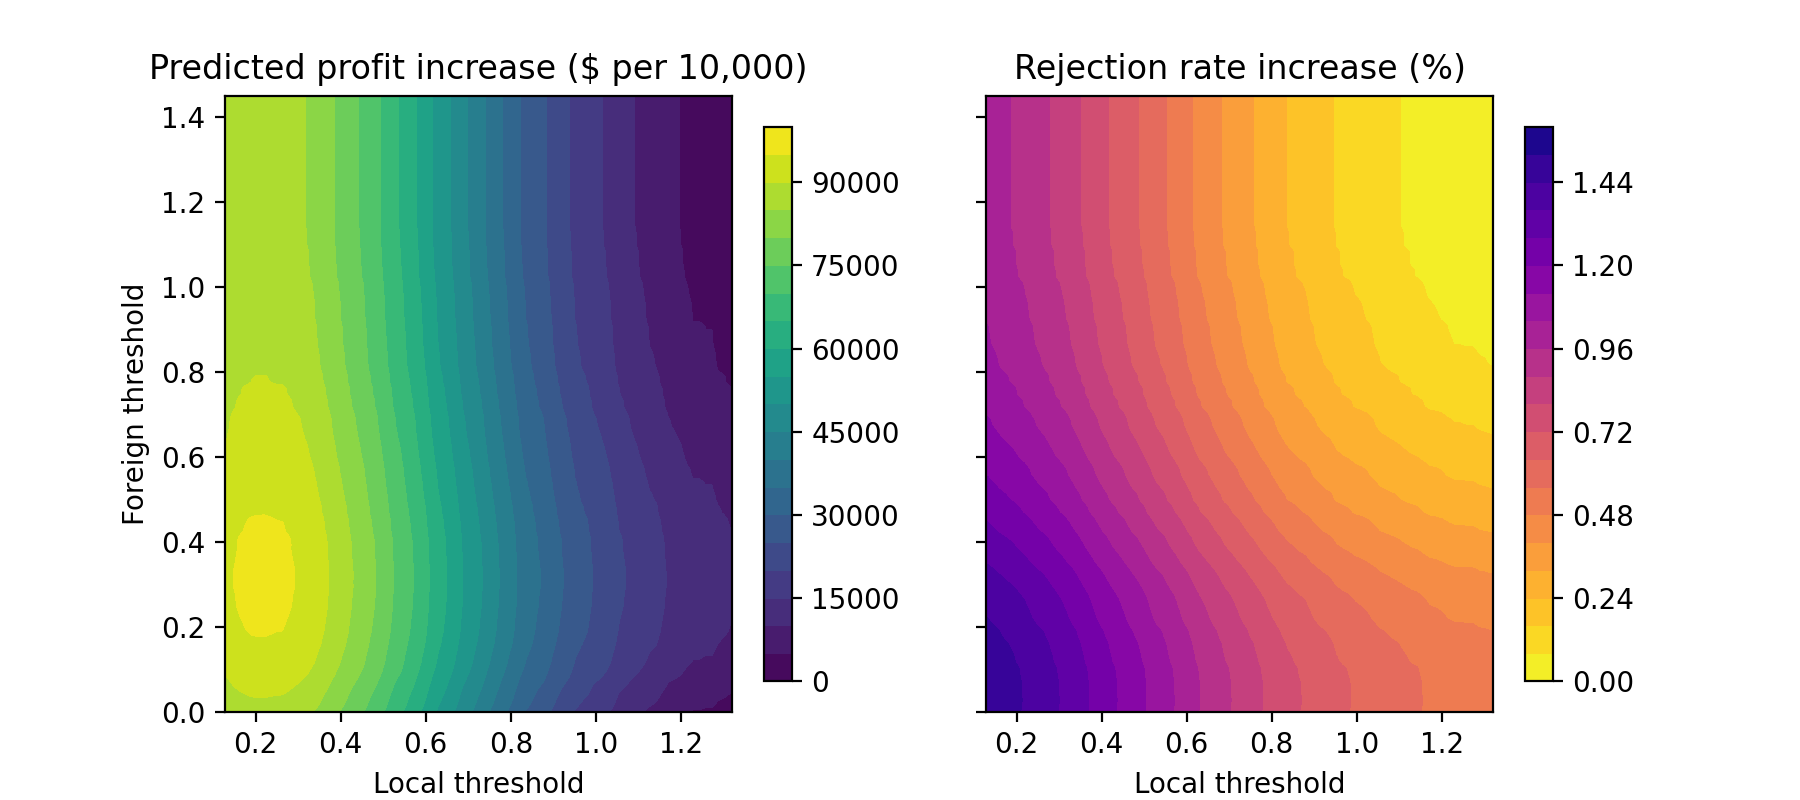

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
f.subplots_adjust(hspace=0.3)

pcm1 = ax1.contourf(FT, LT, EPROFIT, levels=20)
ax1.set_title("Predicted profit increase ($ per 10,000)")
ax1.set_ylabel("Foreign threshold")
ax1.set_xlabel("Local threshold")
f.colorbar(pcm1, ax=ax1, shrink=0.9)
ax1.axis("equal")

pcm2 = ax2.contourf(FT, LT, ERHARM, levels=20, cmap="plasma_r")
ax2.set_title("Rejection rate increase (%)")
ax2.set_xlabel("Local threshold")
f.colorbar(pcm2, ax=ax2, shrink=0.9)
ax2.axis("equal")

plt.show()

In [17]:
max_prof_f, max_prof_l = np.unravel_index(np.argmax(EPROFIT), shape=EPROFIT.shape)
max_prof_thresh_f = threshs[max_prof_f]
max_prof_thresh_l = threshs[max_prof_l]
max_prof = EPROFIT[max_prof_f, max_prof_l]
max_prof_harm = ERHARM[max_prof_f, max_prof_l]

print(f"Max profit = ${max_prof:.2f}")
print(f"Harm rate = {max_prof_harm:.3f}")
print(f"Thesholds foreign: {max_prof_thresh_f:.3f}, local: {max_prof_thresh_l:.3f}")

Max profit = $96222.95
Harm rate = 1.319
Thesholds foreign: 0.322, local: 0.220


## Profit vs. Harms

For a maximum number of rejection harms, what is the max profit (and thresholds) we can achieve per group? These decompose for a set max level of harm per group, so we can analyse them separately.

### Foreign profit vs. harm

<IPython.core.display.Javascript object>


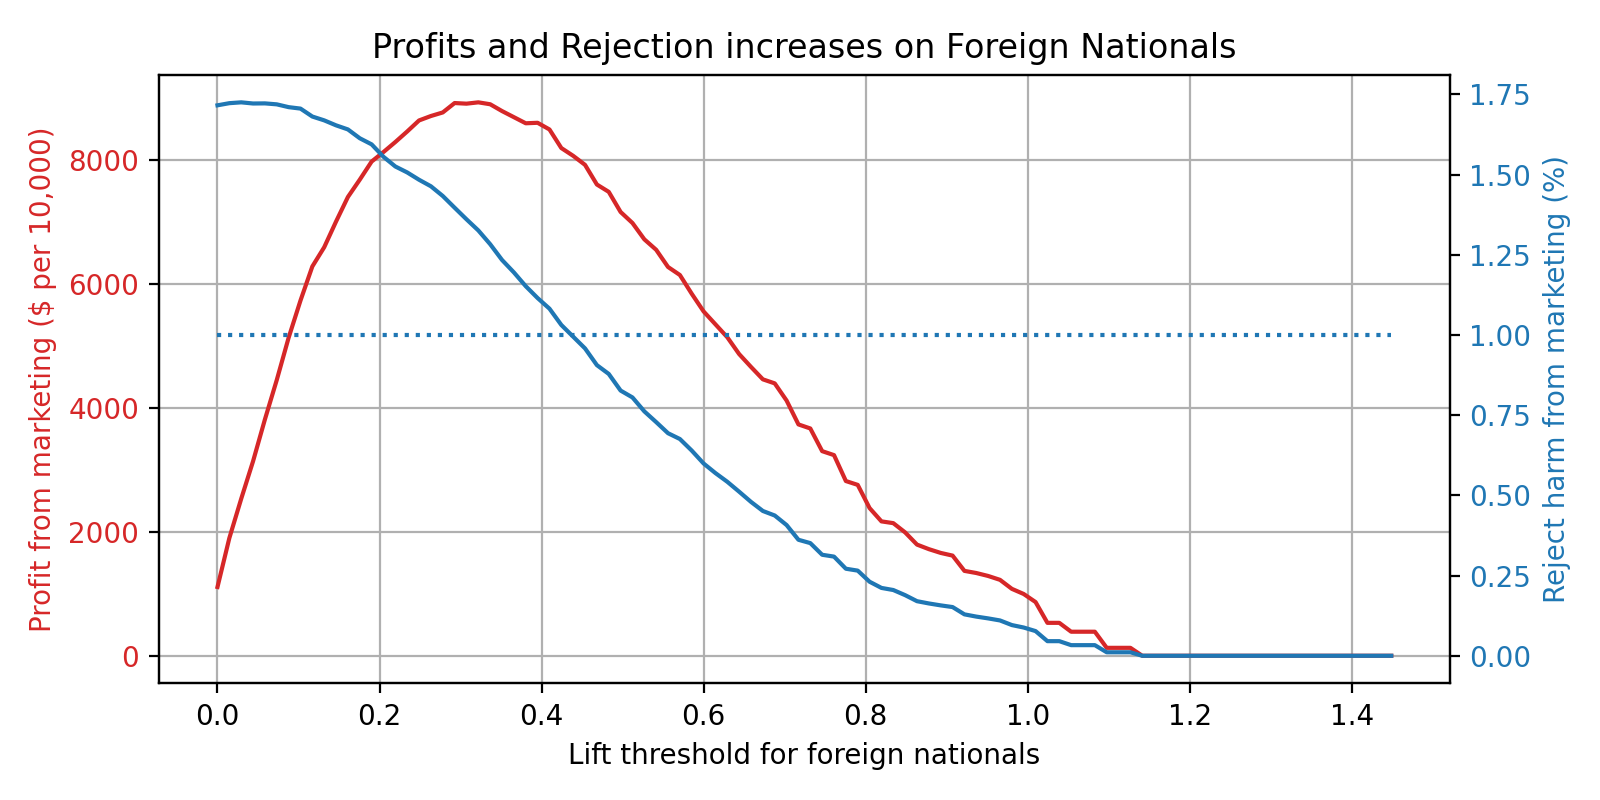

In [18]:
def filter_pred_outcomes(pred_outcomes, mask):
    filtered_outcomes = {k: v[mask] for k, v in pred_outcomes.items()}
    return filtered_outcomes
    
f_eprofit = np.zeros_like(threshs)
f_eharms = np.zeros_like(threshs)

for i, f_thresh in enumerate(threshs):
    select = lift[isforeign] > f_thresh
    f_poutcomes = filter_pred_outcomes(poutcomes, isforeign)
    f_eprofit[i] = expected_profit(f_poutcomes, select)
    f_eharms[i] = expected_reject_harm(f_poutcomes, select)
    
fig, ax1 = plt.subplots(figsize=(8, 4))
color = 'tab:red'
ax1.set_title("Profits and Rejection increases on Foreign Nationals")
ax1.set_xlabel('Lift threshold for foreign nationals')
ax1.set_ylabel(f'Profit from marketing ($ per 10,000)', color=color)
ax1.plot(threshs, f_eprofit, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Reject harm from marketing (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(threshs, f_eharms, color=color)
ax2.plot([0, max_lift], [1, 1], color=color, linestyle=":")
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<IPython.core.display.Javascript object>


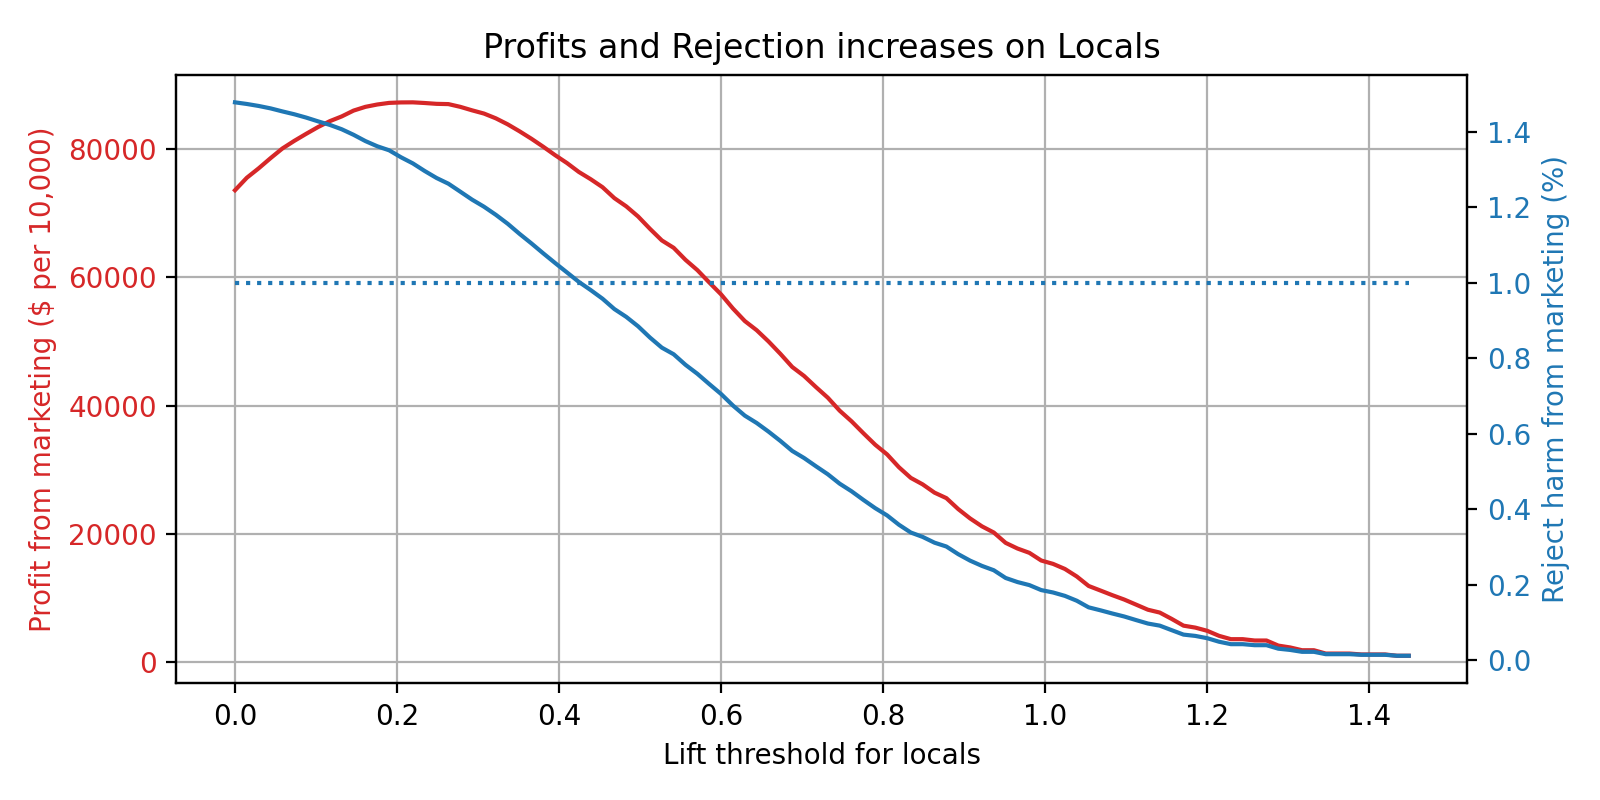

In [19]:
l_eprofit = np.zeros_like(threshs)
l_eharms = np.zeros_like(threshs)

for i, l_thresh in enumerate(threshs):
    select = lift[~isforeign] > l_thresh
    l_poutcomes = filter_pred_outcomes(poutcomes, ~isforeign)
    l_eprofit[i] = expected_profit(l_poutcomes, select)
    l_eharms[i] = expected_reject_harm(l_poutcomes, select)
    
fig, ax1 = plt.subplots(figsize=(8, 4))
color = 'tab:red'
ax1.set_title("Profits and Rejection increases on Locals")
ax1.set_xlabel('Lift threshold for locals')
ax1.set_ylabel(f'Profit from marketing ($ per 10,000)', color=color)
ax1.plot(threshs, l_eprofit, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Reject harm from marketing (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(threshs, l_eharms, color=color)
ax2.plot([0, max_lift], [1, 1], color=color, linestyle=":")
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Profit vs. Harms vs. Fairness (disparity)

We can also analyse the "fairness" surface of rejection rate increase difference between the local and foreigner cohorts. This is not a specific objective of the system, but is analysed anyway for completeness.

To plot rejection rate lift difference between local vs. foreign we need to compute:

$\mathrm{Z}(\textrm{Acq}{=}0, \textrm{App}{=}1 | A{=}\textrm{foreign}) - \mathrm{Z}(\textrm{Acq}{=}0, \textrm{App}{=} 1 | A{=}\textrm{local})$.

Here 0 means there is no difference, negative means a lower rejection rate for foreigners compared to locals, and positive means high rejection rates for foreigners compared to locals.

We'll also plot the chosen lift thresholds given in the text (0.4 on locals, 0.5 on foreigners).

**NOTE** - a conservative threshold was chosen for foreigners in case the deployment cohort has a slightly different behaviour or the model has more generalisation error on this cohort (as they have less representation in the data).

In [20]:
# Calculate difference of rejection rate lift
DIFF_RR = np.zeros((GRID_POINTS, GRID_POINTS))

for i, f_rr in enumerate(f_eharms):
    for j, l_rr in enumerate(l_eharms):
        DIFF_RR[i, j] = f_rr - l_rr

<IPython.core.display.Javascript object>


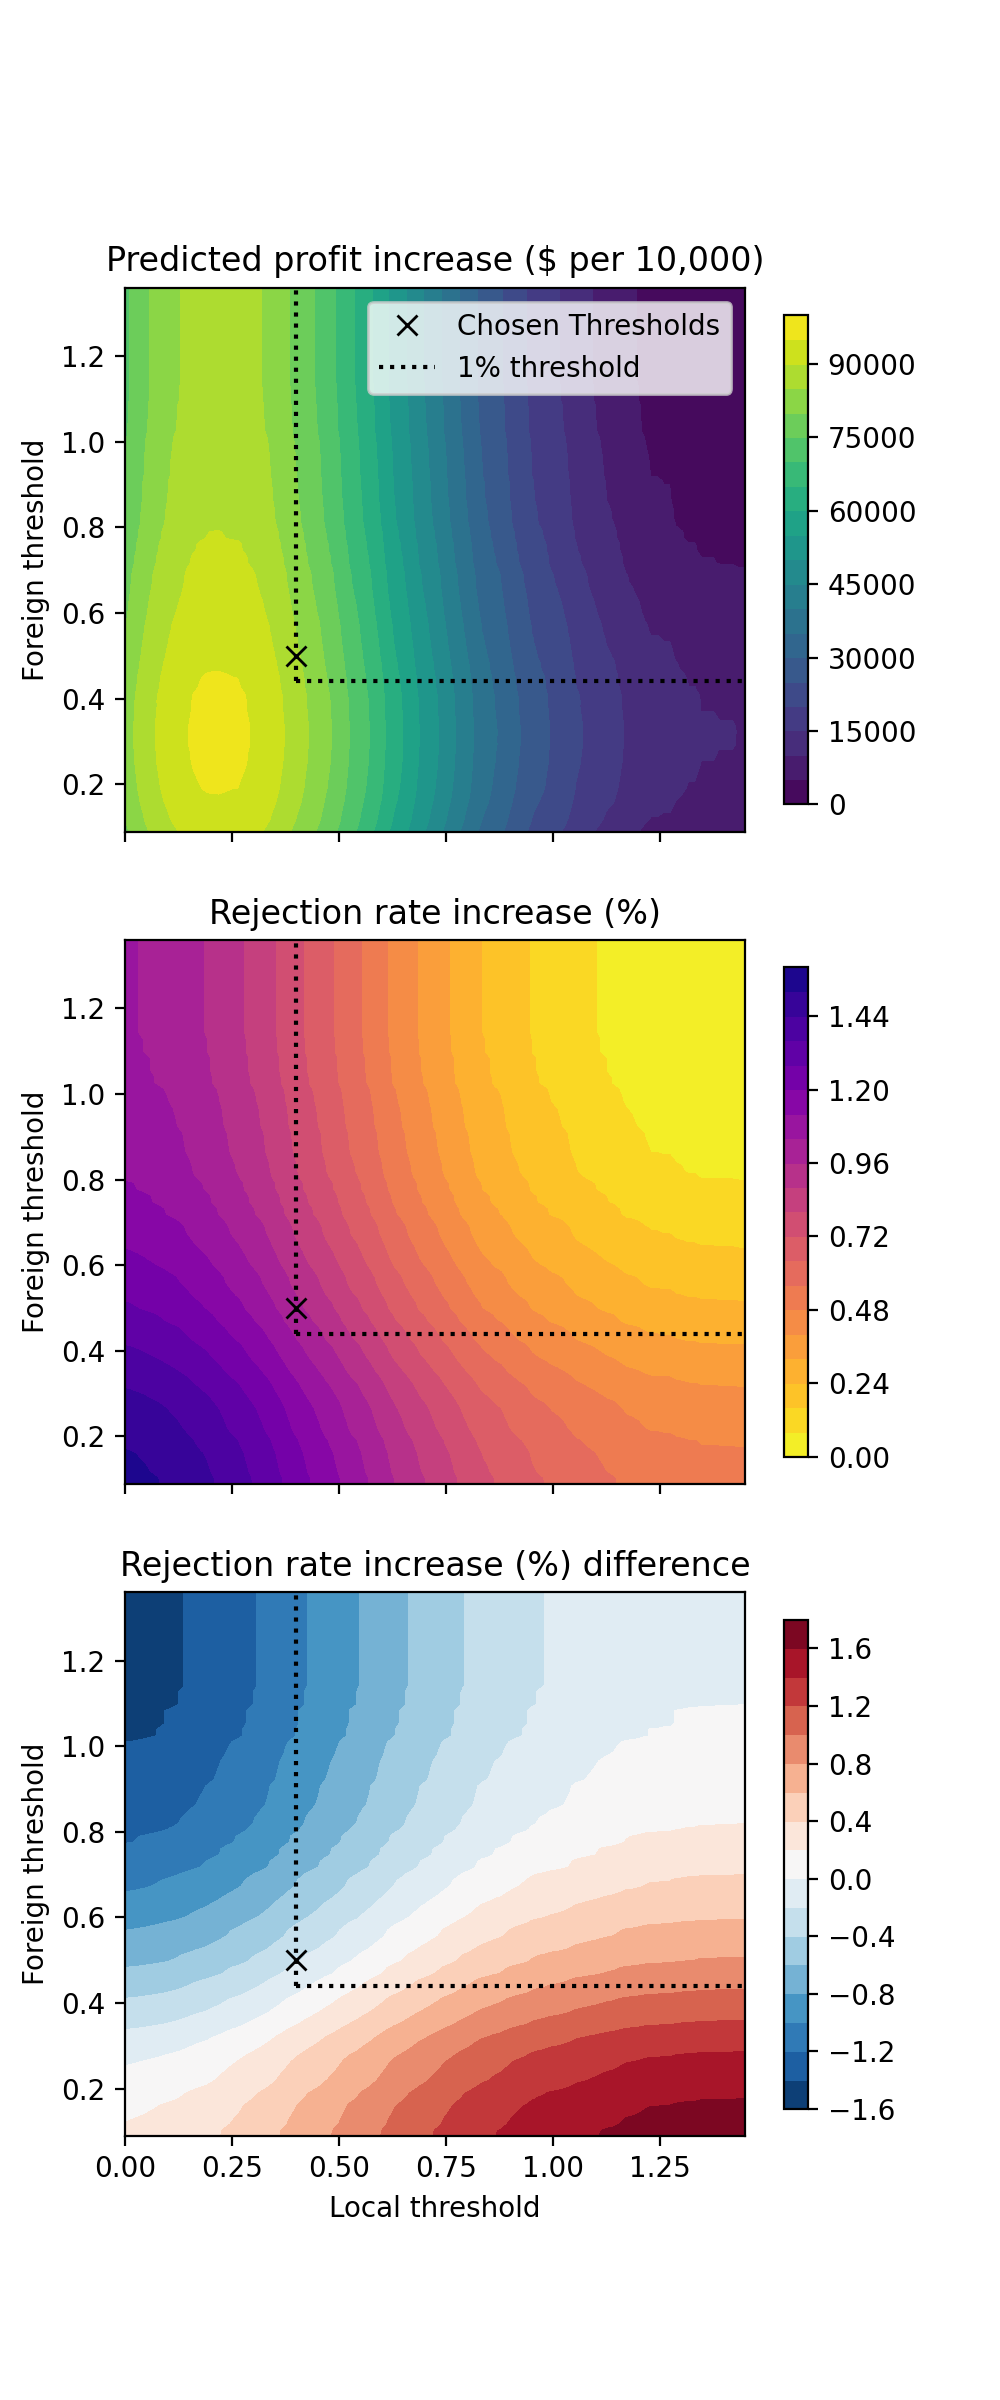

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 12))
#f.subplots_adjust(vspace=0.3)

l_thresh = 0.4
f_thresh = 0.5
f_one_perc = 0.44
l_one_perc = 0.4

pcm1 = ax1.contourf(FT, LT, EPROFIT, levels=20)
ax1.set_title("Predicted profit increase ($ per 10,000)")
ax1.plot([l_thresh], [f_thresh], 'xk', markersize=7, label="Chosen Thresholds")
ax1.plot([l_one_perc, l_one_perc], [f_one_perc, max_lift], ':k', label="1% threshold")
ax1.plot([l_one_perc, max_lift], [f_one_perc, f_one_perc], ':k')
ax1.set_ylabel("Foreign threshold")
f.colorbar(pcm1, ax=ax1, shrink=0.9)
ax1.axis("equal")
ax1.legend()

pcm2 = ax2.contourf(FT, LT, ERHARM, levels=20, cmap="plasma_r")
ax2.plot([0.4], [0.5], 'xk', markersize=7, label="Chosen Thresholds")
ax2.plot([l_one_perc, l_one_perc], [f_one_perc, max_lift], ':k', label="1% threshold")
ax2.plot([l_one_perc, max_lift], [f_one_perc, f_one_perc], ':k')
ax2.set_title("Rejection rate increase (%)")
ax2.set_ylabel("Foreign threshold")
f.colorbar(pcm2, ax=ax2, shrink=0.9)
ax2.axis("equal")

pcm3 = ax3.contourf(FT, LT, DIFF_RR, levels=20, cmap="RdBu_r")
ax3.plot([0.4], [0.5], 'xk', markersize=7, label="Chosen Thresholds")
ax3.plot([l_one_perc, l_one_perc], [f_one_perc, max_lift], ':k', label="1% threshold")
ax3.plot([l_one_perc, max_lift], [f_one_perc, f_one_perc], ':k')
ax3.set_title("Rejection rate increase (%) difference")
ax3.set_ylabel("Foreign threshold")
ax3.set_xlabel("Local threshold")
f.colorbar(pcm3, ax=ax3, shrink=0.9)
ax3.axis("equal")

plt.show()

## Deployment Analysis

Now this system will be deployed on 10,000 people and the outcomes will be measured.

Lift thresholds of
- 0.4 on locals
- 0.5 on foreigners

Keeps the rejection rates of these two cohorts at around 1% because of the system - but is slightly conservative for foreigners.

In [22]:
# Modify selection function
selectionfn = partial(diff_threshold, column="isforeign", groups=[0, 1], thresholds=[0.4, 0.5])
outclf.predictors["lift"].set_selectionfn(selectionfn)

### Rejection estimation on outcomes

How many more rejections are due to the marketing system? (As a percentage of the cohort)

\begin{align}
\mathrm{Z}(\textrm{Acq}{=}0 , \textrm{App}{=}1) \approx&~ \frac{1}{N} \sum_{i \in \mathcal{S}} 
    \mathbf{1}(\textrm{Acq}_i {=} 0 \wedge \textrm{App}_i {=} 1)
    - \mathrm{P}_c(\textrm{Acq}_i{=}0, \textrm{App}_i{=}1 | \mathbf{x}_i) \\
\end{align}

Where $\mathcal{R} = \{n \in \{1, \ldots, N\} | R_n=1\}$ and $\mathrm{P}(\textrm{Acq}_i{=}0, \textrm{App}_i{=}0) = 0$.

In [23]:
def reject_deploy(out_dep, out_ctl, selection, outcomes):
    pRejcC = outcomes['reject_control'][selection]
    out_deploy_selected = out_dep[selection]
    reject_TR = sum(out_deploy_selected.acquired[out_deploy_selected.applied == 1] == 0)
    reject_CR = sum(pRejcC)
    reject_harm = (reject_TR - reject_CR) / len(selection)
    return reject_harm * 100

### Profit estimation on outcomes

\begin{align}
\mathbb{E}[\textrm{Profit}] \approx
    \sum_{i \in \mathcal{S}}
    \mathbf{1}(\textrm{Acq}_i{=}1 \wedge \textrm{App}_i{=}1) \times \textrm{Profit}(\textrm{Acq}_i{=}1, S_i{=}1)
    - \mathrm{P}_c(\textrm{Acq}_i{=}1, \textrm{App}_i{=}1|\mathbf{x}_i)\times \textrm{Profit}(\textrm{Acq}_i{=}1, S_i{=}0) \\
\end{align}

Since $\textrm{Profit}(\textrm{Acq}_i{=}0, S_i{=}t) = 0$.

In [24]:
def profit_deploy(out_dep, out_ctl, selected, outcomes):
    pRcC = outcomes['lift_control'][selected]
    profit_control = sum(pRcC * PROFIT_RESPOND)
    
    # Profit from selection
    profit_selection = sum(out_dep.acquired[selected] * PROFIT_RESPOND - COST_TREATMENT)
    profit = profit_selection - profit_control
    return profit

Deployment - Number selected for intervention and measures

In [25]:
def number_selected(out_dep, out_ctl, selected, outcomes):
    return sum(selected)

Deploy the system and get results

In [26]:
deployment_scorers = {
    "est. profit": make_impacts(profit_deploy),
    "est. profit fo": make_fair_impacts(profit_deploy, prot_attr="isforeign", reported_group=1),
    "est. profit lo": make_fair_impacts(profit_deploy, prot_attr="isforeign", reported_group=0), 
    "est. profit F": make_fair_impacts(profit_deploy, prot_attr="isfemale", reported_group=1),
    "est. profit M": make_fair_impacts(profit_deploy, prot_attr="isfemale", reported_group=0), 
    "est. reject %": make_impacts(reject_deploy),
    "est. reject % fo": make_fair_impacts(reject_deploy, prot_attr="isforeign", reported_group=1),
    "est. reject % lo": make_fair_impacts(reject_deploy, prot_attr="isforeign", reported_group=0),
    "est. reject % F": make_fair_impacts(reject_deploy, prot_attr="isfemale", reported_group=1),
    "est. reject % M": make_fair_impacts(reject_deploy, prot_attr="isfemale", reported_group=0),
    "ben. receive": make_impacts(benefit_from_receive),
    "ben. receive fo": make_fair_impacts(benefit_from_receive, prot_attr="isforeign", reported_group=1),
    "ben. receive lo": make_fair_impacts(benefit_from_receive, prot_attr="isforeign", reported_group=0),
    "ben. receive F": make_fair_impacts(benefit_from_receive, prot_attr="isfemale", reported_group=1),
    "ben. receive M": make_fair_impacts(benefit_from_receive, prot_attr="isfemale", reported_group=0),
    "ben. acquire": make_impacts(benefit_from_acquire),
    "ben. acquire fo": make_fair_impacts(benefit_from_acquire, prot_attr="isforeign", reported_group=1),
    "ben. acquire lo": make_fair_impacts(benefit_from_acquire, prot_attr="isforeign", reported_group=0),
    "no. selected": make_impacts(number_selected),
    "no. selected fo": make_fair_impacts(number_selected, prot_attr="isforeign", reported_group=1),
    "no. selected lo": make_fair_impacts(number_selected, prot_attr="isforeign", reported_group=0),
}

deploy_outcomes = mock_deploy(outclf, Xd, yd, ytr, deployment_scorers)
   
display_outcomes(deploy_outcomes)

,lower 5%,mean,upper 95%
est. profit,80952.481767,88087.492037,95499.185482
est. profit fo,5537.322084,7315.252109,9597.641327
est. profit lo,75256.545942,80772.239929,88242.254016
est. profit F,25440.450029,29742.100632,34237.168083
est. profit M,52736.750513,58345.391406,64548.758784
est. reject %,0.610769,0.775741,0.952804
est. reject % fo,0.665555,0.873112,1.155391
est. reject % lo,0.552338,0.734564,0.924960
est. reject % F,0.113059,0.458554,0.706324
est. reject % M,0.756158,0.983263,1.245145


Now let's look at how the selection is distributed w.r.t. age and income. It would be more difficult to estimate profit and rejection rate this way since these are not positive-only quantities.

In [27]:
# Discretise a continuous attribute into percentiles
def discrete_percentiles(X, n_percentiles):
    percentiles = np.arange(n_percentiles)
    perc_idx = pd.qcut(X, n_percentiles, labels=percentiles)
    return percentiles, perc_idx


# Probability-Probability curves
def pp_curve(resource, prt_att, n_percentiles=20):
    # Cut the cohort protected attribute into percentiles
    percentiles, perc_idx = discrete_percentiles(prt_att, n_percentiles)
    
    # Get the cumulative distribution of resource allocation
    #  by the protected attribute percentiles
    hist = np.array([sum(resource[perc_idx == p]) for p in percentiles])
    cum_resource = np.cumsum(hist) / sum(resource)
    
    # Start the curves at zero
    cum_resource = np.insert(cum_resource, 0, 0)
    percentiles = np.linspace(0, 1, n_percentiles + 1)
    return cum_resource, percentiles


def mean_percentiles(resource, prt_att, n_percentiles=20):
    # Cut the cohort protected attribute into percentiles
    percentiles, perc_idx = discrete_percentiles(prt_att, n_percentiles)
    
    mean = np.array([np.mean(resource[perc_idx == p]) for p in percentiles])
    percentiles = np.linspace(0, 1, n_percentiles)
    return mean, percentiles


def pp_plot(resource, outcomes, prt_att, att_name, benefit_name, n_percentiles=20):
    cum_resource, rpercentiles = pp_curve(resource, prt_att, n_percentiles)
    lift = outcomes["lift_treatment"] - outcomes["lift_control"]
    mean_lift, mpercentiles = mean_percentiles(lift, prt_att, n_percentiles)
    
    fig, ax1 = plt.subplots(figsize=(7, 7))
    color = 'tab:blue'
    ax1.set_title(f"{benefit_name} by {att_name} P-P Curve")
    ax1.set_xlabel(f"{att_name} percentile")
    ax1.set_ylabel(f"Cumulative {benefit_name}", color=color)
    ax1.plot(rpercentiles, cum_resource, color=color)#, label="Cumulative Allocation")
    ax1.plot([rpercentiles[0], rpercentiles[-1]], [0, 1], 'g--', label="Line of Equality")
    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.set_axis("equal")
    ax1.grid()
    ax1.legend()
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    ax2.set_ylabel('Average predicted product lift, $\hat{\mathrm{Z}}(\mathrm{App}=1, \mathrm{Acq=1} | A=a)$', color=color)
    ax2.plot(mpercentiles, mean_lift, color=color, label="Mean lift")
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

<IPython.core.display.Javascript object>


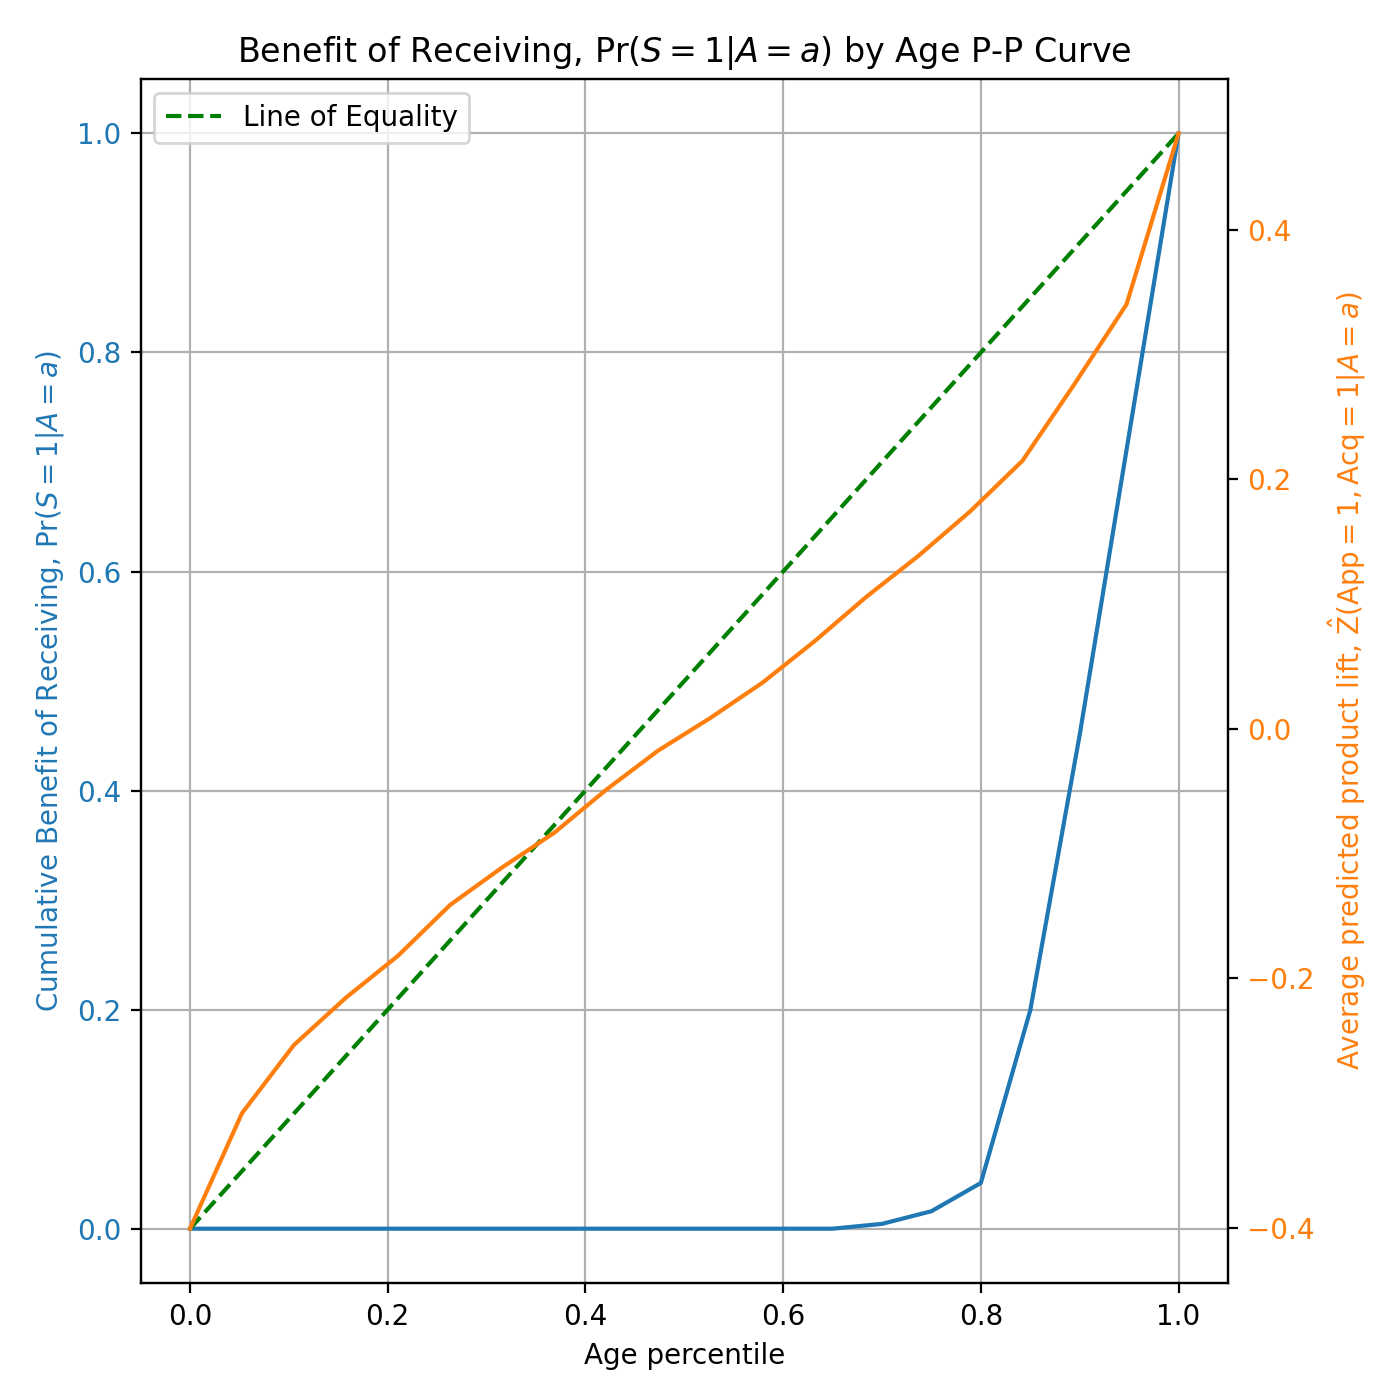

<IPython.core.display.Javascript object>


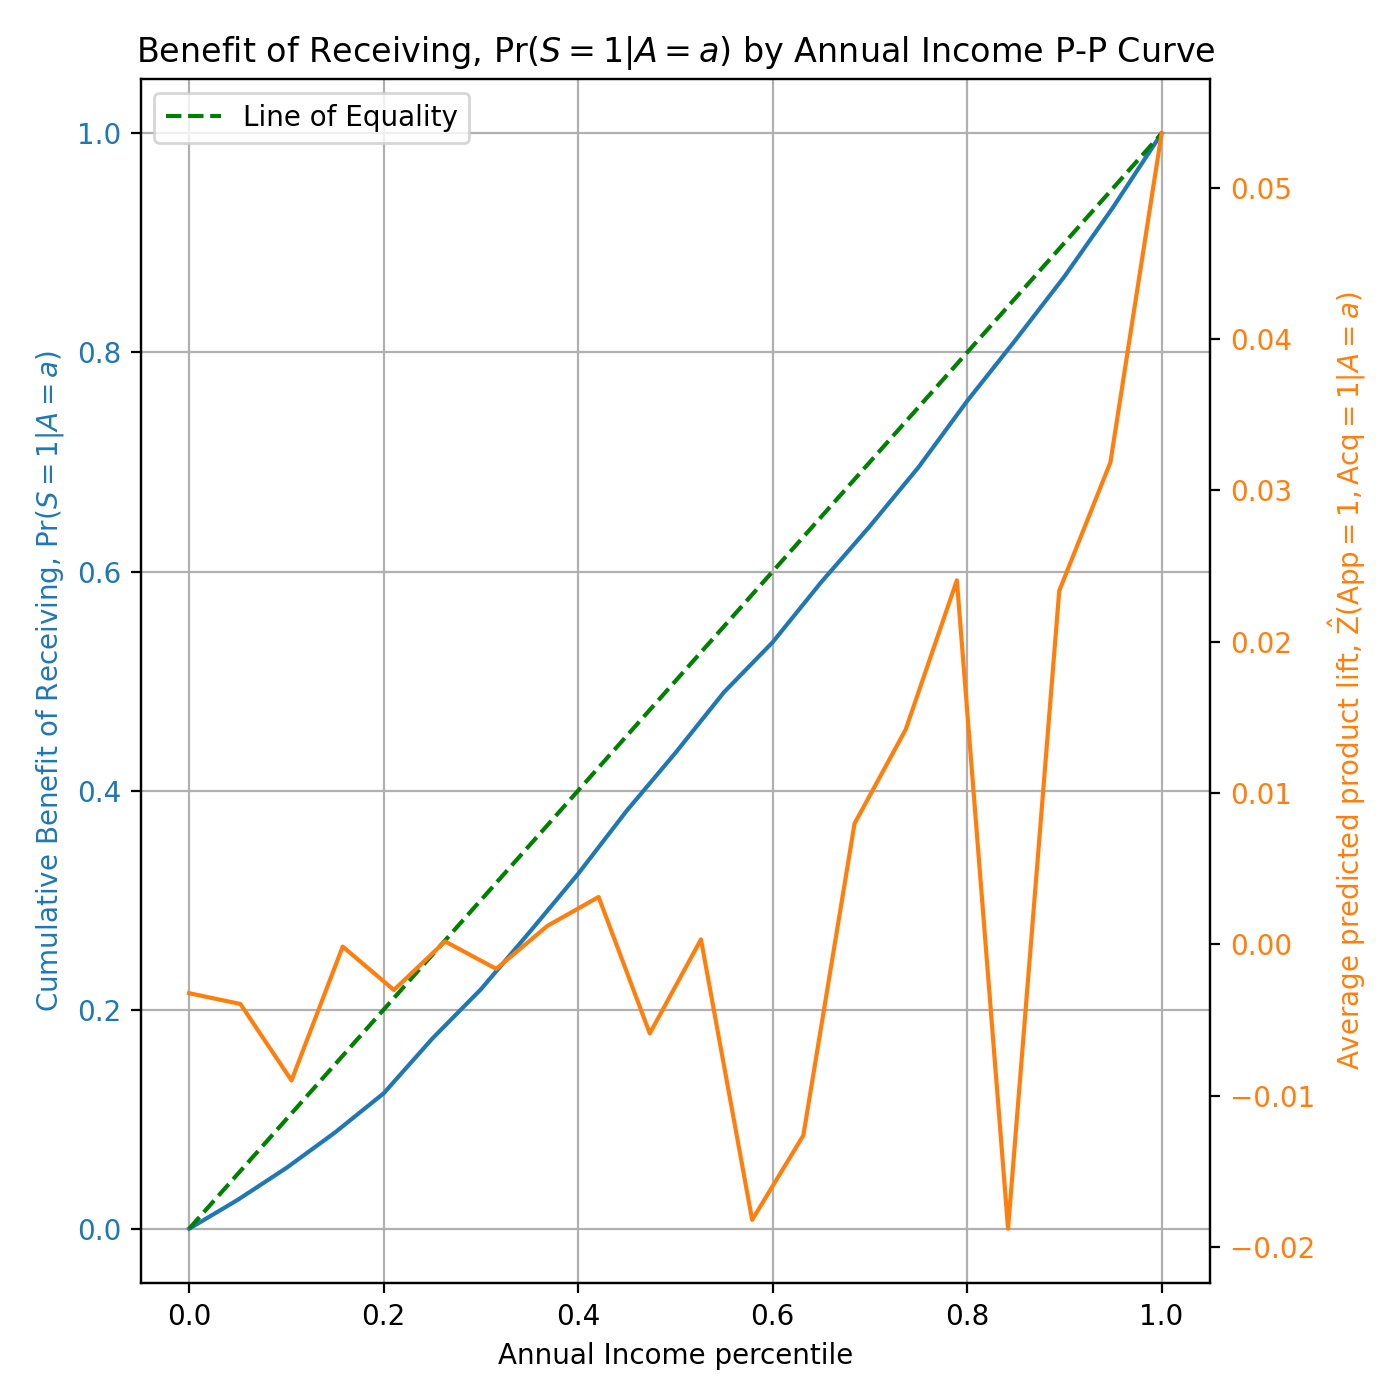

In [28]:
selection = outclf.select(Xd)
pred_outcomes = outclf.predict_outcomes(Xd)

pp_plot(selection, pred_outcomes, Ad.age, "Age", "Benefit of Receiving, $\mathrm{Pr}(S=1 | A=a)$")

pp_plot(selection, pred_outcomes, Xd.income, "Annual Income", "Benefit of Receiving, $\mathrm{Pr}(S=1 | A=a)$")